In [26]:
# Загрузка датасета из репозитория гит
!git clone https://github.com/nikitosl/spbu-nlp-2020.git
import sys
sys.path.append('./spbu-nlp-2020')

fatal: destination path 'spbu-nlp-2020' already exists and is not an empty directory.


In [27]:
%pip install youtokentome

In [28]:
# Импорты
import re

import pandas as pd
import numpy as np
from collections import Counter

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time
import torch
from torchtext import data, datasets
import youtokentome as yttm
from torch.nn import TransformerEncoder, TransformerEncoderLayer, \
                     TransformerDecoder, TransformerDecoderLayer
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Dataset
from torch.optim.lr_scheduler import MultiplicativeLR

### Параметры

In [93]:
BATCH_SIZE = 128
VOCAB_SIZE = 500
PART_LEN = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PAD_IDX = 0
SOS_IDX = 2
EOS_IDX = 3

EMBEDDING_DIM = 128

ENCODER_HEADS_NUMBER = 16
INTERNAL_DIM = 128
ENCODER_LAYERS_NUM = 2
DROPOUT = 0.1

### Функции

In [94]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch[0].T.to(device) # [InLen, BS]
        tgt = batch[1].T.to(device) # [OutLen, BS]
        
        optimizer.zero_grad()
        
        output_tgt = model(src) # [OutLen, BS, VS]
        output_tgt = output_tgt.reshape(-1, VOCAB_SIZE) # [OutLen * BS, VS]
        
        tgt = tgt.reshape(-1) # [OutLen * BS]
        loss = criterion(output_tgt, tgt)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0].T.to(device) # [InLen, BS]
            tgt = batch[1].T.to(device) # [OutLen, BS]
                        
            output_tgt = model(src)
            output_tgt = output_tgt.reshape(-1, output_tgt.shape[-1])
            
            tgt = tgt.reshape(-1)
            loss = criterion(output_tgt, tgt)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, out_len=100, pad_value=0):
        self.texts = texts
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item][:-1]
        target = self.texts[item][1:]
        

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)
        
        target = ensure_length(target, self.out_len, self.pad_value)
        target = torch.tensor(target, dtype=torch.long)

        return txt, target

### Чтение файла Война и мир, BPE

In [95]:
with open('./spbu-nlp-2020/deep_learning/war_and_peace.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [96]:
model_path = './spbu-nlp-2020/deep_learning/models/bpe.model'
train_data_path = "./spbu-nlp-2020/deep_learning/war_and_peace.txt"

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=VOCAB_SIZE, model=model_path,
               pad_id=0, unk_id=1, bos_id=2, eos_id=3)

# Loading model
bpe = yttm.BPE(model=model_path)

In [97]:
bpe.vocab()

['<PAD>',
 '<UNK>',
 '<BOS>',
 '<EOS>',
 '▁',
 'о',
 'а',
 'е',
 'и',
 'н',
 'т',
 'с',
 'л',
 'в',
 'р',
 'к',
 'д',
 ',',
 'м',
 'у',
 'п',
 'я',
 'ь',
 'г',
 'ы',
 'з',
 'б',
 'ч',
 '.',
 'й',
 'ж',
 'ш',
 'х',
 '–',
 '\xa0',
 'ю',
 'e',
 'ц',
 'щ',
 'Н',
 'э',
 's',
 'n',
 'r',
 'i',
 'a',
 'П',
 '-',
 'u',
 'o',
 't',
 'А',
 'ф',
 'В',
 'l',
 '3',
 ';',
 'О',
 '!',
 '?',
 '2',
 'К',
 'Б',
 'm',
 'Д',
 'М',
 'd',
 'c',
 'С',
 'Р',
 '&',
 '#',
 '…',
 'И',
 'p',
 'Т',
 'v',
 ':',
 'Я',
 '»',
 '«',
 '’',
 '4',
 'h',
 'Г',
 '1',
 'ъ',
 ']',
 '[',
 'Э',
 'Ч',
 'Е',
 'q',
 'f',
 ')',
 '(',
 'g',
 'b',
 'Л',
 '5',
 'I',
 '8',
 '0',
 'З',
 'У',
 '6',
 '9',
 '7',
 'z',
 'j',
 'Ж',
 'V',
 'M',
 'B',
 'A',
 'X',
 'Ф',
 'Х',
 'x',
 'Ш',
 'L',
 'y',
 'C',
 'J',
 'N',
 'P',
 'ё',
 'k',
 'E',
 'S',
 'D',
 'Ц',
 'w',
 'R',
 'T',
 'Q',
 'O',
 'G',
 'F',
 '/',
 'H',
 'U',
 'K',
 'Ю',
 '_',
 '*',
 'W',
 '„',
 '“',
 'Z',
 '—',
 'Щ',
 '>',
 '<',
 'Й',
 '▁с',
 'то',
 '▁в',
 '▁п',
 '▁н',
 '▁о',
 '▁и',
 '

In [98]:
# text_parts = [text[i:i + PART_LEN] for i in range(0, len(text), PART_LEN)]
# Разбиваем по предложениям
text_parts = text.split('.')
text_parts = [part for part in text_parts if len(part) > 0 and len(part) < PART_LEN]
encoded_parts = bpe.encode(text_parts, bos=True, eos=True)

In [99]:
dataset = PaddedSequenceDataset(encoded_parts, out_len=PART_LEN, pad_value=0)

train_len = int(len(dataset) * 0.9)
valid_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, valid_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [100]:
print(len(train_dataset), len(val_dataset))

12654 1406


In [101]:
train_dataset[0]

(tensor([  2,   4, 115, 111, 100, 262,  16, 206,  23, 260, 210, 269,  13, 329,
         184, 388, 208,  12,  20,   6, 210, 164, 293, 186,  17, 315, 224, 226,
         186, 388, 447,  21, 183, 318,  16, 224, 226, 186, 388, 161, 450,  30,
         289, 170, 358,  32, 436, 166,  19, 484, 349,  32, 199,   4, 321, 239,
         404, 231, 189, 358, 185,  32, 210,   8,  23, 165,  13, 269,  29, 179,
          19,  25,  24, 213,  17, 250, 432, 215, 449, 202,  14,  22,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

### Модель

In [102]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe) # [5000, 1, ES]

    def forward(self, x):
        x = x + self.pe[:x.size(0), :] # [XLen, BS, ES]
        return self.dropout(x)
      
class text_generator_transformer(nn.Module):
    def __init__(self, 
                 vocab_size, embedding_dim, device, pad_idx, sos_idx, eos_idx, dropout,
                 enc_heads_num, enc_internal_dim, enc_layers_num):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoding = PositionalEncoding(embedding_dim, dropout)
        self.device = device
        self.embedding_dim = embedding_dim

        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx

        encoder_layer = TransformerEncoderLayer(embedding_dim, enc_heads_num, enc_internal_dim, dropout)
        self.encoder = TransformerEncoder(encoder_layer, enc_layers_num)

        self.out = nn.Linear(embedding_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def generate_padding_mask(self, seq):
        mask = (seq == self.pad_idx).transpose(1, 0) # [BS, SeqLen]
        return mask

    def forward(self, src):
        #src = [InLen, BS]
        batch_size = src.shape[1]
        in_len = src.shape[0]

        src_embed = self.embedding(src) * math.sqrt(self.embedding_dim) # [InLen, BS, ED]
        src_embed = self.pos_encoding(src_embed)
        src_padding_mask = self.generate_padding_mask(src) # [BS, InLen]
        src_dependency_mask = self.generate_square_subsequent_mask(in_len).to(self.device)

        encoder_output = self.encoder(src_embed, 
                                      mask=src_dependency_mask,
                                      src_key_padding_mask=src_padding_mask) # [InLen, BS, ED]

        logists = self.out(encoder_output) # [OutLen, BS, VS]

        return logists

    def get_source(self, s=None):
        if s:
            source = torch.tensor(bpe.encode(s, bos=True)).reshape((-1, 1))
            source_len = source.shape[0]
            template = torch.zeros((PART_LEN, 1)).long().fill_(self.sos_idx)
            result = torch.cat((source, template), dim=0).to(self.device)
        else:
            result = torch.zeros((PART_LEN, 1)).long().fill_(self.sos_idx).to(self.device) # [MaxLen, 1]
            source_len = 1
        
        return result, source_len
        


    def inference(self, start_sentence=None):

        tgt, start_i = self.get_source(start_sentence)
        
        for i in range(start_i, PART_LEN):
            filled_tgt = tgt[:i, :]
            tgt_embed = self.embedding(filled_tgt) * math.sqrt(self.embedding_dim) # [i, 1, ED]
            tgt_embed = self.pos_encoding(tgt_embed)
            src_dependency_mask = self.generate_square_subsequent_mask(tgt_embed.shape[0]).to(self.device)
            
            encoder_output = self.encoder(tgt_embed, mask=src_dependency_mask) # [InLen, 1, ED]

            last_token_embed = encoder_output[-1, :, :]
            last_token_logists = self.out(last_token_embed).squeeze(0) # [VS]
            scores = torch.softmax(last_token_logists, dim=0)
            last_token_index = torch.multinomial(scores, 1)[0]
            # last_token_index = torch.argmax(last_token_logists) # [1]
            tgt[i, :] = last_token_index

            if last_token_index == self.eos_idx:
                break
        return tgt[:i+1, 0]

In [103]:
model = text_generator_transformer(
      VOCAB_SIZE, EMBEDDING_DIM, device, dropout=DROPOUT,
      pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX,
      enc_heads_num=ENCODER_HEADS_NUMBER, enc_internal_dim=INTERNAL_DIM, enc_layers_num=ENCODER_LAYERS_NUM,
).to(device)

### TEST

In [54]:
output = model.inference('Привет')
output_text = bpe.decode(output.tolist(), ignore_ids=[0, 1, 2, 3])
print('Predict: ', ' '.join(output_text))

Predict:  ПриветA всефирел моперьСтичеW Истьм,в, Марьет,мот себя графгб ме прецеГтьелине былаядвно дацену его будДV спзо –  спса мнещга слогля


### Initialization

In [113]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

text_generator_transformer(
  (embedding): Embedding(500, 128)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
      

In [114]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 327,668 trainable parameters


### Обучение модели

In [115]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)

Adjusting learning rate of group 0 to 5.0000e-03.


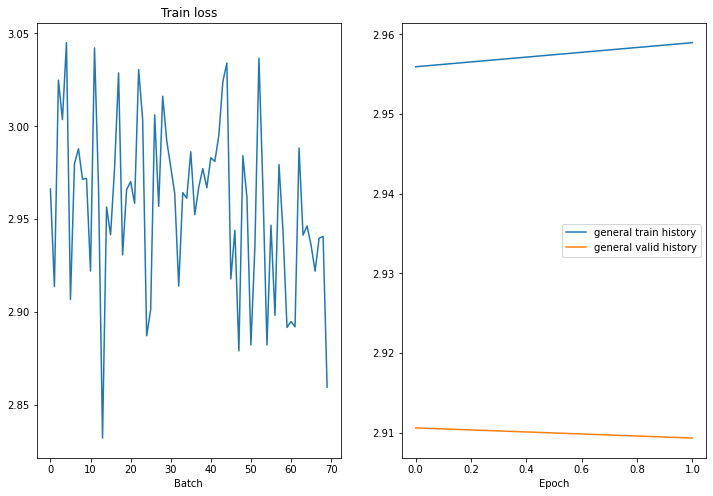

KeyboardInterrupt: ignored

In [120]:
MODEL_NAME = './spbu-nlp-2020/deep_learning/models/transformer.pt'
N_EPOCHS = 500
CLIP = 1

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    scheduler.step()
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME) 
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Анализ результатов

In [57]:
# for cpu usage
model.load_state_dict(torch.load('./spbu-nlp-2020/deep_learning/models/transformer100.pt', 
                                 map_location=torch.device(device)))

<All keys matched successfully>

In [117]:
test_loss = evaluate(model, valid_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.910 | Test PPL:  18.361 |


In [127]:
torch.save(model.state_dict(), './spbu-nlp-2020/deep_learning/models/transformer_vocab500_epoch250.pt')

In [145]:
output = model.inference('Я')
output_text = bpe.decode(output.tolist(), ignore_ids=[0, 1, 2, 3])
print('Predict: ', ' '.join(output_text))

Predict:  Я знаю, что они перешлияную неумы исполнить ему
